# Victor Palacios

In [2]:
!pip install torchsummary

In [3]:
import os
import cv2
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

# data augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# pretrained models
import torchvision
from torchvision import models, transforms
from torchsummary import summary

# Question 1

## -1 (batch size) x 64 (filters) x 1/2 (original height) x 1/2 (original width)

# Each layer changes BECAUSE ...

# Question 2

In [4]:
# create a dataframe for our image data
data_path = '../input/animal-faces/afhq'

rows = []
for dataset in os.listdir(data_path):
    for label in os.listdir(data_path + f'/{dataset}'):
        for image in os.listdir(data_path + f'/{dataset}' + f'/{label}'):
            row = dict()
            row['image_file'] = image
            row['label'] = label
            row['dataset'] = dataset
        
            # a bit redudant, could build from other data in __getitem__ if wanted
            row['image_path'] = data_path + f'/{dataset}' + f'/{label}'
            rows.append(row)
        
df = pd.DataFrame(rows)
print(len(df))
df.head()

16130


,image_file,label,dataset,image_path
0,flickr_dog_000254.jpg,dog,val,../input/animal-faces/afhq/val/dog
1,pixabay_dog_000322.jpg,dog,val,../input/animal-faces/afhq/val/dog
2,flickr_dog_000812.jpg,dog,val,../input/animal-faces/afhq/val/dog
3,flickr_dog_000737.jpg,dog,val,../input/animal-faces/afhq/val/dog
4,pixabay_dog_002383.jpg,dog,val,../input/animal-faces/afhq/val/dog


In [5]:
df.shape

(16130, 4)

In [5]:
# training and validation data
df_train = df[df['dataset'] == 'train'].reset_index(drop=True)
df_val = df[df['dataset'] == 'val'].reset_index(drop=True)
len(df_train), len(df_val)

(14630, 1500)

In [6]:
%%time
def resize_img(path, size):
    img = cv2.imread(path)
    
    start = time.time()
    img = cv2.resize(img, size)
    end = time.time()
    
    cv2.imwrite(path, img)
    return end - start

# resize all of the images to 256x256
total_time_resize = 0.0
for idx in range(len(df_train)):
    row = df_train.iloc[idx]
    image_path = row['image_path']
    fname = row['image_file']
    path = image_path+'/'+fname
    
    total_time_resize += resize_img(path, (256, 256))
    
for idx in range(len(df_val)):
    row = df_train.iloc[idx]
    image_path = row['image_path']
    fname = row['image_file']
    path = image_path+'/'+fname
    
    total_time_resize += resize_img(path, (256, 256))

CPU times: user 57.6 s, sys: 3.45 s, total: 1min 1s
Wall time: 3min 21s


In [7]:
row = df_train.iloc[100]
image_path = row['image_path']
fname = row['image_file']
path = image_path+'/'+fname
img = cv2.imread(path)

img.shape

(512, 512, 3)

## I chose color jitter and fancy pca and sharpen

In [8]:
# let's add an augmentation option
class AnimalFacesDataset(Dataset):
    def __init__(self, df, augment=False):
        self.df = df
        self.augment = augment
        
        # label dictionary
        self.label_dict = {'cat':0, 'dog':1, 'wild':2}
        
        # define the transformation
        if augment == True:
            self.transforms = A.Compose([
                # spatial transforms
                A.RandomCrop(width=224, height=224),
                A.HorizontalFlip(p=.5),
                A.VerticalFlip(p=.5),
                A.Rotate(limit = 10, 
                         border_mode = cv2.BORDER_CONSTANT, 
                         value = 0.0, p = .75),
                
                # pixel-level transformation
                A.RandomBrightnessContrast(p=0.5),
                
 #####          # Extra augmentation
                A.ColorJitter(brightness=0.8, contrast=0.2, saturation=0.2, hue=0.2, always_apply=True, p=1.0),
                A.FancyPCA(alpha=0.8, always_apply=True, p=1.0),
                A.Sharpen(alpha=(0.2, 0.8), lightness=(0.5, 1.0), always_apply=True, p=1.0),
                
                # we will normalize according to ImageNet since we will be using a pre-trained ResNet
                # this adjusts from [0,255] to [0,1]
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                
                # convert to a tensor and move color channels
                ToTensorV2()
            ])
        else:
            self.transforms = A.Compose([
                # training/valid images have same size
                A.CenterCrop(width=224, height=224),
                
                # normalize
                A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                
                # convert to a tensor and move color channels
                ToTensorV2()
            ])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # get ingredients for retrieving image
        image_path = row['image_path']
        fname = row['image_file']
        path = image_path+'/'+fname
        
        # read the img
        img = cv2.imread(path)
        
        # convert to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # transform the image
        # certain transformations expect the uint8 datatype
        transformed = self.transforms(image=img.astype(np.uint8))
        img = transformed['image']
        
        label = torch.tensor(self.label_dict[row['label']])
        
        return img, label

In [9]:
ds_train = AnimalFacesDataset(df_train, augment=True)
dl_train = DataLoader(ds_train, batch_size=16, shuffle=True)

ds_val = AnimalFacesDataset(df_val)
dl_val = DataLoader(ds_val, batch_size=16, shuffle=True)

torch.Size([3, 224, 224])
tensor(1)


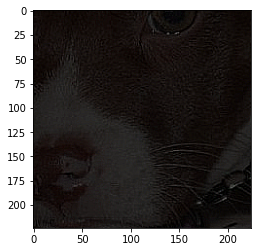

In [10]:
img, label = next(iter(ds_train))
print(img.shape)

# restructure for plt
img = np.transpose(np.array(img), (1,2,0))

# reverse the normalization
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

for i in range(3):
    img[:,:,i] = (img[:,:,i] * std[i]) + mean[i]

plt.imshow(img)
print(label)

# Question 3

## Frozen Resnet

In [14]:
model = models.alexnet(pretrained=True)

In [15]:
# we can see the architecture
# note how many of the layers are organized in "BasicBlock"
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

- Notice how the image eventually becomes a 1D vector of dimension 512
- In some sense the network has transformed an image into a vector of features helpful for image classification
- The last layer is a simple function (linear followed by softmax) on this feature space that predicts an images class
- One strategy is to train a new simple function on this **same** feature space for our classification task

In [16]:
summary(model, input_size = (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [17]:
# turn off gradients for all the parameters
for param in model.parameters():
            param.requires_grad = False

In [21]:
# re-intialize the last layer for our task
print(model.classifier)
model.classifier[6] = nn.Linear(4096, 3)
print(model.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=512, out_features=3, bias=True)
)
Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=3, bias=True)
)


In [23]:
# re-initializing the layer reset to default settings
for param in model.classifier.parameters():
    print(param.requires_grad)

False
False
False
False
True
True


In [24]:
# double-check all the parameters
for name, param in model.named_parameters():
    print(f"{name} gradient is set to", param.requires_grad)

features.0.weight gradient is set to False
features.0.bias gradient is set to False
features.3.weight gradient is set to False
features.3.bias gradient is set to False
features.6.weight gradient is set to False
features.6.bias gradient is set to False
features.8.weight gradient is set to False
features.8.bias gradient is set to False
features.10.weight gradient is set to False
features.10.bias gradient is set to False
classifier.1.weight gradient is set to False
classifier.1.bias gradient is set to False
classifier.4.weight gradient is set to False
classifier.4.bias gradient is set to False
classifier.6.weight gradient is set to True
classifier.6.bias gradient is set to True


In [25]:
# pass the appropriate parameters to the optimizer
params_to_update = []

for param in model.parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = optim.Adam(params_to_update, lr=0.001)

In [34]:
# # let's make sure that this actually freezes/trains the layers, take a sample weight
# print(model.conv1.weight[0])
# print(model.classifier.bias)

In [28]:
device_no = 0
if torch.cuda.is_available() == True:
    device = torch.device(device_no)
else:
    device = torch.device('cpu')

model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [29]:
def one_pass(model, dataloader, optimizer, lossFun, device, backwards=True, print_loss=False):
    
    if backwards == True:
        model.train()
    else:
        model.eval()
    
    total_loss = 0.0
    for x, y in dataloader:
        
        # send labelled data to the device
        x, y = x.to(device), y.to(device)
        
        y_pred = model(x)
        loss = lossFun(y_pred, y)
        total_loss += loss.item()
        
        if backwards == True:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    avg_loss = total_loss / len(dataloader)
    
    if print_loss == True:
        print(avg_loss)
    
    return avg_loss

In [30]:
def one_pass_acc(model, dataloader, num_points):
    model.eval()
    total_incorrect = 0
    
    softmax = nn.LogSoftmax(dim=1)
    
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        y_pred = softmax(model(x))
        y_pred = torch.argmax(y_pred, dim=1)
        
        total_incorrect += torch.count_nonzero(y - y_pred).item()
        
    percent_wrong = total_incorrect / num_points
    return 1 - percent_wrong

In [33]:
%%time

lossFun = nn.CrossEntropyLoss()

num_epochs = 1
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    print('Epoch: ', epoch)
    train_loss = one_pass(model, dl_train, optimizer, lossFun, device)
    train_losses.append(train_loss)
    print('Train loss: ', train_loss)
    
    valid_loss = one_pass(model, dl_val, optimizer, lossFun, device, backwards=False)
    valid_losses.append(valid_loss)
    print('Valid loss: ', valid_loss)
    
    train_acc = one_pass_acc(model, dl_train, len(ds_train))
    valid_acc = one_pass_acc(model, dl_val, len(ds_val))
    print('Train Acc: ', train_acc)
    print('Valid Acc: ', valid_acc)

Epoch:  0
Train loss:  0.7348093462202067
Valid loss:  0.29115655590245065
Train Acc:  0.7492139439507861
Valid Acc:  0.8953333333333333
CPU times: user 6min 38s, sys: 26 s, total: 7min 3s
Wall time: 6min 47s


In [32]:
# print(resnet.conv1.weight[0])
# print(resnet.fc.bias)

If we want to finetune, we can either
- use the resnet as a starting point and train by treating the pretrained weights as good weight initilaization OR
- we can train different layers at different learning rates (the later the layer, the more we want to adjust the feature)

In [36]:
# we can pass the optimizer groups of parameters rather than all the parameters in one group
for param_group in optimizer.param_groups:
    print(param_group)

{'params': [Parameter containing:
tensor([[-4.2733e-03,  3.2866e-02,  3.0109e-03,  ..., -7.0366e-03,
         -1.9164e-02, -4.7682e-03],
        [-2.6442e-02, -3.2126e-02, -2.3669e-03,  ..., -7.0967e-03,
          2.4094e-02, -2.3762e-02],
        [ 3.8296e-03,  8.3673e-05, -2.0321e-03,  ...,  1.5356e-02,
         -6.2015e-03,  9.8737e-03]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([-0.0002, -0.0007,  0.0167], device='cuda:0', requires_grad=True)], 'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}


In [37]:
for name, layer in model.named_children():
    print(name)

features
avgpool
classifier


In [38]:
max_lr = 0.01
params = []
for i, layer in enumerate(model.children()):
    if i < 6:
        params.append({'params': layer.parameters(), 'lr': max_lr / 100})
    elif 5 < i < 9:
        params.append({'params': layer.parameters(), 'lr': max_lr / 10})
    else:
        params.append({'params': layer.parameters()})
        
# only the parameters we didn't manually set the learning rate for inherit the learning rate set when defining the optimizer
optimizer = optim.Adam(params, lr=max_lr)

In [39]:
# we can see the parameters groups here
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0

Parameter Group 2
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)

## Finetuned AlexNet

In [1]:
class Tuned_Model(nn.Module):
    def __init__(self):
        super(Tuned_Model, self).__init__()
        model = models.alexnet(pretrained=True)
        layers = list(model.children())[:9]
        print(layers)
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.classifier = nn.Linear(512, 3)
        self.unroll = nn.Flatten()
    
    def forward(self, x):
        print(x.shape)
        x = self.features1(x)
        print(x.shape)
        x = self.features2(x)
        print(x.shape)
        x = self.unroll(x)
        x = self.classifier(x)
        return x
    
model = Tuned_Model()
summary(model, input_size = (3, 224, 224), device='cpu')

NameError: name 'nn' is not defined

## Scratch Alexnet

In [30]:
model = models.alexnet(pretrained=False)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [15]:
# we can see the architecture
# note how many of the layers are organized in "BasicBlock"
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

- Notice how the image eventually becomes a 1D vector of dimension 512
- In some sense the network has transformed an image into a vector of features helpful for image classification
- The last layer is a simple function (linear followed by softmax) on this feature space that predicts an images class
- One strategy is to train a new simple function on this **same** feature space for our classification task

In [16]:
summary(model, input_size = (3, 224, 224), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [17]:
# turn off gradients for all the parameters
for param in model.parameters():
            param.requires_grad = False

In [21]:
# re-intialize the last layer for our task
print(model.classifier)
model.classifier[6] = nn.Linear(4096, 3)
print(model.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=512, out_features=3, bias=True)
)
Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=3, bias=True)
)


In [23]:
# re-initializing the layer reset to default settings
for param in model.classifier.parameters():
    print(param.requires_grad)

False
False
False
False
True
True


In [24]:
# double-check all the parameters
for name, param in model.named_parameters():
    print(f"{name} gradient is set to", param.requires_grad)

features.0.weight gradient is set to False
features.0.bias gradient is set to False
features.3.weight gradient is set to False
features.3.bias gradient is set to False
features.6.weight gradient is set to False
features.6.bias gradient is set to False
features.8.weight gradient is set to False
features.8.bias gradient is set to False
features.10.weight gradient is set to False
features.10.bias gradient is set to False
classifier.1.weight gradient is set to False
classifier.1.bias gradient is set to False
classifier.4.weight gradient is set to False
classifier.4.bias gradient is set to False
classifier.6.weight gradient is set to True
classifier.6.bias gradient is set to True


In [25]:
# pass the appropriate parameters to the optimizer
params_to_update = []

for param in model.parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = optim.Adam(params_to_update, lr=0.001)

In [ ]:
# # let's make sure that this actually freezes/trains the layers, take a sample weight
# print(model.conv1.weight[0])
# print(model.classifier.bias)

In [28]:
device_no = 0
if torch.cuda.is_available() == True:
    device = torch.device(device_no)
else:
    device = torch.device('cpu')

model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [29]:
def one_pass(model, dataloader, optimizer, lossFun, device, backwards=True, print_loss=False):
    
    if backwards == True:
        model.train()
    else:
        model.eval()
    
    total_loss = 0.0
    for x, y in dataloader:
        
        # send labelled data to the device
        x, y = x.to(device), y.to(device)
        
        y_pred = model(x)
        loss = lossFun(y_pred, y)
        total_loss += loss.item()
        
        if backwards == True:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    avg_loss = total_loss / len(dataloader)
    
    if print_loss == True:
        print(avg_loss)
    
    return avg_loss

In [30]:
def one_pass_acc(model, dataloader, num_points):
    model.eval()
    total_incorrect = 0
    
    softmax = nn.LogSoftmax(dim=1)
    
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        y_pred = softmax(model(x))
        y_pred = torch.argmax(y_pred, dim=1)
        
        total_incorrect += torch.count_nonzero(y - y_pred).item()
        
    percent_wrong = total_incorrect / num_points
    return 1 - percent_wrong

In [ ]:
%%time

lossFun = nn.CrossEntropyLoss()

num_epochs = 1
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    print('Epoch: ', epoch)
    train_loss = one_pass(model, dl_train, optimizer, lossFun, device)
    train_losses.append(train_loss)
    print('Train loss: ', train_loss)
    
    valid_loss = one_pass(model, dl_val, optimizer, lossFun, device, backwards=False)
    valid_losses.append(valid_loss)
    print('Valid loss: ', valid_loss)
    
    train_acc = one_pass_acc(model, dl_train, len(ds_train))
    valid_acc = one_pass_acc(model, dl_val, len(ds_val))
    print('Train Acc: ', train_acc)
    print('Valid Acc: ', valid_acc)

Epoch:  0
Train loss:  0.7348093462202067
Valid loss:  0.29115655590245065


In [32]:
# print(resnet.conv1.weight[0])
# print(resnet.fc.bias)

If we want to finetune, we can either
- use the resnet as a starting point and train by treating the pretrained weights as good weight initilaization OR
- we can train different layers at different learning rates (the later the layer, the more we want to adjust the feature)

In [42]:
# we can pass the optimizer groups of parameters rather than all the parameters in one group
for param_group in optimizer.param_groups:
    print(param_group)

{'params': [Parameter containing:
tensor([[-0.1010, -0.0175, -0.0615,  ...,  0.0042,  0.0339,  0.0486],
        [ 0.0900,  0.0677,  0.0675,  ..., -0.0408,  0.0630,  0.0344],
        [ 0.0468,  0.0136, -0.0037,  ..., -0.0231, -0.0464, -0.0125]],
       requires_grad=True), Parameter containing:
tensor([-0.0373, -0.0075,  0.0246], requires_grad=True)], 'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}


In [43]:
for name, layer in model.named_children():
    print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [44]:
max_lr = 0.01
params = []
for i, layer in enumerate(model.children()):
    if i < 6:
        params.append({'params': layer.parameters(), 'lr': max_lr / 100})
    elif 5 < i < 9:
        params.append({'params': layer.parameters(), 'lr': max_lr / 10})
    else:
        params.append({'params': layer.parameters()})
        
# only the parameters we didn't manually set the learning rate for inherit the learning rate set when defining the optimizer
optimizer = optim.Adam(params, lr=max_lr)

In [45]:
# we can see the parameters groups here
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0

Parameter Group 2
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0

Parameter Group 3
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0

Parameter Group 4
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0

Parameter Group 5
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0

Parameter Group 6
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0

Parameter Group 7
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0

Parameter Group 8
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weigh